In [1]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.1.0/en_core_web_sm-3.1.0-py3-none-any.whl

In [2]:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [1]:
import tensorflow as tf

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [4]:
import spacy
from textblob import TextBlob
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [5]:
df=pd.read_csv(r"F:\downloads\aspect-level\AllProductReviews.csv")
df.head()

,ReviewTitle,ReviewBody,ReviewStar,Product
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255


In [6]:
df.shape

(14337, 4)

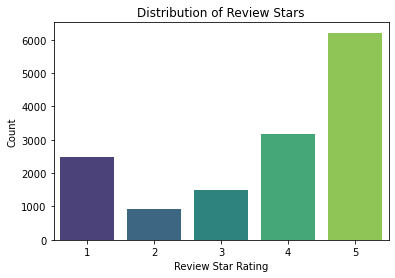

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x='ReviewStar', data=df, palette='viridis')
plt.title('Distribution of Review Stars')
plt.xlabel('Review Star Rating')
plt.ylabel('Count')
plt.show()

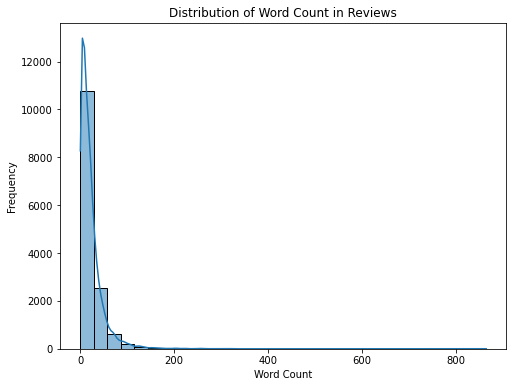

In [8]:
df['word_count'] = df['ReviewBody'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,6))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Count in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords

In [10]:
custom_stopwords = list(sklearn_stopwords)
custom_stopwords

['through',
 'within',
 'toward',
 'full',
 'we',
 'all',
 'during',
 'eight',
 'there',
 'side',
 'more',
 'third',
 'latterly',
 'fire',
 'it',
 'its',
 'yourself',
 'had',
 'a',
 'six',
 'enough',
 'our',
 'seems',
 'de',
 'not',
 'upon',
 'indeed',
 'me',
 'thereafter',
 're',
 'noone',
 'everywhere',
 'nobody',
 'wherever',
 'anyhow',
 'too',
 'put',
 'besides',
 'inc',
 'name',
 'forty',
 'twenty',
 'move',
 'amoungst',
 'thus',
 'seeming',
 'how',
 'less',
 'fill',
 'meanwhile',
 'everything',
 'see',
 'already',
 'to',
 'sixty',
 'her',
 'elsewhere',
 'any',
 'few',
 'hereupon',
 'behind',
 'con',
 'by',
 'throughout',
 'do',
 'from',
 'them',
 'again',
 'anyone',
 'become',
 'whatever',
 'bill',
 'system',
 'after',
 'must',
 'whereafter',
 'of',
 'thereby',
 'ie',
 'call',
 'down',
 'in',
 'anyway',
 'at',
 'five',
 'why',
 'eg',
 'whole',
 'are',
 'ourselves',
 'somewhere',
 'was',
 'herself',
 'mine',
 'hundred',
 'between',
 'sincere',
 'made',
 'keep',
 'via',
 'fifty',
 

In [11]:
def preprocess(text):
    doc = nlp(text.lower())  # Lowercase the text
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in custom_stopwords]  # Lemmatization and stopword removal
    return ' '.join(tokens)
df['cleaned_review'] = df['ReviewBody'].apply(preprocess)
print(df[['ReviewBody', 'cleaned_review']].head())

                                          ReviewBody  \
0  No doubt it has a great bass and to a great ex...   
1  This  earphones are unreliable, i bought it be...   
2  i bought itfor 999,I purchased it second time,...   
3  Its sound quality is adorable. overall it was ...   
4  Its Awesome... Good sound quality & 8-9 hrs ba...   

                                      cleaned_review  
0  doubt great bass great extent noise cancellati...  
1  earphone unreliable buy day right ear bud got ...  
2  buy itfor purchase second time gifted brother ...  
3  sound quality adorable overall good just week ...  
4  awesome good sound quality hrs battery life ju...  


In [12]:
df['cleaned_review']

0        doubt great bass great extent noise cancellati...
1        earphone unreliable buy day right ear bud got ...
2        buy itfor purchase second time gifted brother ...
3        sound quality adorable overall good just week ...
4        awesome good sound quality hrs battery life ju...
                               ...                        
14332                                                 good
14333                           amazing product bit costly
14334                                                sound
14335    sound good battery life good wire long good pr...
14336    m write review use month stop work n mail conc...
Name: cleaned_review, Length: 14337, dtype: object

In [13]:
nlp = spacy.load('en_core_web_sm')

In [14]:
irrelevant_words = {"the", "is", "a", "an", "and", "this", "that", "with", "in", "on", "for", "of", "to", "it", "be", "by"}


In [15]:
def extract_aspects_loose(review):
    doc = nlp(review)
    aspects = set()

    # Capture noun chunks and nouns directly, without heavy filtering
    for chunk in doc.noun_chunks:
        aspect_text = chunk.text.strip().lower()
        if len(aspect_text) > 1:
            aspects.add(aspect_text)

    # Add adjectives modifying nouns (amod) and noun-verb pairs (nsubj)
    for token in doc:
        if token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
            aspects.add(f"{token.text} {token.head.text}".lower())
        if token.dep_ == 'nsubj' and token.head.pos_ == 'VERB':
            aspects.add(f"{token.text} {token.head.text}".lower())

    # No filtering by known aspects, just remove irrelevant words
    refined_aspects = [aspect for aspect in aspects if aspect not in irrelevant_words]
    
    return refined_aspects

In [16]:
df['aspects'] = df['cleaned_review'].apply(extract_aspects_loose)

In [17]:
df['aspects']

0        [sound clarity, person keep, conical bit, mic ...
1        [crack, thing, part, proof attach, unreliable ...
2        [second time, gifted brother, device connect, ...
3             [sound quality, work power claim, just week]
4        [rupee amazon, bad packaging, just rupee amazo...
                               ...                        
14332                                                   []
14333                                        [amazing bit]
14334                                              [sound]
14335    [good product, good life, long product, good w...
14336    [ready query, just brand value, ready reslove ...
Name: aspects, Length: 14337, dtype: object

In [18]:
# Count rows where 'aspects' column has empty lists
empty_aspects_count = df['aspects'].apply(lambda x: len(x) == 0).sum()

print(f"Number of entries with empty lists in 'aspects': {empty_aspects_count}")


Number of entries with empty lists in 'aspects': 1439


In [19]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Assuming your dataframe is called 'data' and contains the columns 'cleaned_review' and 'aspects'

# Initialize the VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment score for each aspect
def aspect_sentiment_analysis(review, aspects):
    sentiment_dict = {}
    
    # Analyze sentiment for each aspect
    for aspect in aspects:
        aspect_sentences = [sentence for sentence in review.split('.') if aspect in sentence]  # Filter sentences containing the aspect
        aspect_text = ' '.join(aspect_sentences)  # Join those sentences
        
        if aspect_text:  # Ensure there's text to analyze
            scores = sid.polarity_scores(aspect_text)
            compound_score = scores['compound']
            if compound_score >= 0.05:
                sentiment_dict[aspect] = 'positive'
            elif compound_score <= -0.05:
                sentiment_dict[aspect] = 'negative'
            else:
                sentiment_dict[aspect] = 'neutral'
        else:
            sentiment_dict[aspect] = 'neutral'
    
    return sentiment_dict

# Apply the sentiment analysis to each row of your dataframe
df['aspect_sentiment'] = df.apply(lambda x: aspect_sentiment_analysis(x['cleaned_review'], x['aspects']), axis=1)

# Show a sample of the dataframe
print(df[['aspects', 'aspect_sentiment']].head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                             aspects  \
0  [sound clarity, person keep, conical bit, mic ...   
1  [crack, thing, part, proof attach, unreliable ...   
2  [second time, gifted brother, device connect, ...   
3       [sound quality, work power claim, just week]   
4  [rupee amazon, bad packaging, just rupee amazo...   

                                    aspect_sentiment  
0  {'sound clarity': 'negative', 'person keep': '...  
1  {'crack': 'positive', 'thing': 'positive', 'pa...  
2  {'second time': 'positive', 'gifted brother': ...  
3  {'sound quality': 'positive', 'work power clai...  
4  {'rupee amazon': 'positive', 'bad packaging': ...  


In [20]:
df['aspects']

0        [sound clarity, person keep, conical bit, mic ...
1        [crack, thing, part, proof attach, unreliable ...
2        [second time, gifted brother, device connect, ...
3             [sound quality, work power claim, just week]
4        [rupee amazon, bad packaging, just rupee amazo...
                               ...                        
14332                                                   []
14333                                        [amazing bit]
14334                                              [sound]
14335    [good product, good life, long product, good w...
14336    [ready query, just brand value, ready reslove ...
Name: aspects, Length: 14337, dtype: object

In [21]:
df['aspect_sentiment']

0        {'sound clarity': 'negative', 'person keep': '...
1        {'crack': 'positive', 'thing': 'positive', 'pa...
2        {'second time': 'positive', 'gifted brother': ...
3        {'sound quality': 'positive', 'work power clai...
4        {'rupee amazon': 'positive', 'bad packaging': ...
                               ...                        
14332                                                   {}
14333                           {'amazing bit': 'neutral'}
14334                                 {'sound': 'neutral'}
14335    {'good product': 'positive', 'good life': 'neu...
14336    {'ready query': 'neutral', 'just brand value':...
Name: aspect_sentiment, Length: 14337, dtype: object

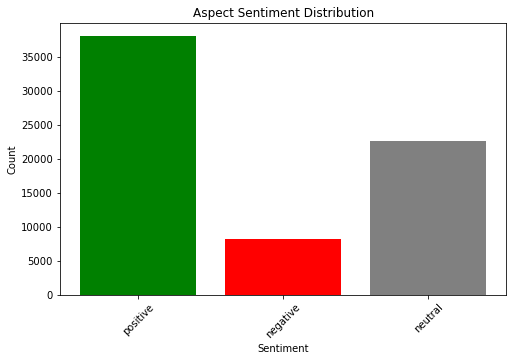

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Flattening the aspect sentiments for easier analysis
sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}

# Iterate through the aspect_sentiment column
for sentiment_dict in df['aspect_sentiment']:
    for sentiment in sentiment_dict.values():
        if sentiment in sentiment_counts:
            sentiment_counts[sentiment] += 1

# Create a DataFrame for visualization
sentiment_df = pd.DataFrame(list(sentiment_counts.items()), columns=['Sentiment', 'Count'])

# Plotting the sentiment distribution
plt.figure(figsize=(8, 5))
plt.bar(sentiment_df['Sentiment'], sentiment_df['Count'], color=['green', 'red', 'gray'])
plt.title('Aspect Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [23]:
# Remove rows where 'aspect_sentiment' is empty
cleaned_data = df[df['aspect_sentiment'].apply(lambda x: bool(x))]

In [24]:
# Create a DataFrame to hold the aspects and sentiments
train_data = []

for sentiment_dict in cleaned_data['aspect_sentiment']:
    for aspect, sentiment in sentiment_dict.items():
        train_data.append((aspect, sentiment))

# Convert to DataFrame
train_df = pd.DataFrame(train_data, columns=['Aspect', 'Sentiment'])

# Check the resulting DataFrame
print(train_df.head())


          Aspect Sentiment
0  sound clarity  negative
1    person keep  negative
2    conical bit   neutral
3     mic person  negative
4   great extent  negative


In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [26]:
texts=train_df['Aspect'].values
labels=train_df['Sentiment'].values

In [27]:
texts

array(['sound clarity', 'person keep', 'conical bit', ...,
       'work n mail concern jbl year warranty', 'review',
       'warranty believe'], dtype=object)

In [28]:
label_map = {'negative': 0, 'positive': 1,'neutral':2}
y = [label_map[label] for label in labels]

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
sequences

[[3, 31],
 [99, 311],
 [2292, 76],
 [29, 99],
 [11, 600],
 [11, 5, 11, 600, 23, 22, 67, 3, 31, 2293, 9, 1349, 845, 177],
 [515, 50],
 [17, 99],
 [28, 2],
 [11, 177],
 [976, 131],
 [141, 16, 164],
 [976, 131, 17, 28, 2, 4438, 29, 99],
 [67, 31],
 [576],
 [53],
 [870],
 [435, 779],
 [1457, 41],
 [4439],
 [3, 2],
 [138, 402],
 [5, 1, 34, 435],
 [576, 402],
 [1, 34],
 [184, 24],
 [1962, 755],
 [61, 89],
 [2837, 51, 9, 12],
 [107, 238],
 [2838, 93],
 [91, 2],
 [1, 8, 536, 51],
 [1, 51],
 [61],
 [4440, 55],
 [93, 238],
 [755, 89],
 [107, 614],
 [107, 238, 61],
 [1458, 93],
 [245, 107, 614, 2838, 1458, 93],
 [3, 2],
 [10, 277, 324],
 [80, 187],
 [312, 38],
 [17, 293],
 [80, 312, 38],
 [44, 293],
 [13, 1, 3, 2, 251, 9, 12],
 [13, 12],
 [3, 2],
 [17, 44, 293],
 [38],
 [2839, 293],
 [1, 2],
 [10, 86],
 [41, 52, 1117, 10],
 [1963, 212, 66, 69, 41, 34],
 [34, 558],
 [12,
  2,
  1,
  358,
  394,
  689,
  1058,
  1,
  2,
  6,
  20,
  1,
  96,
  2,
  1,
  3,
  479,
  5,
  228,
  74,
  4441,
  100,
  

In [30]:
maxlen = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [44]:
padded_sequences.shape

(68920, 26)

In [43]:
padded_sequences = padded_sequences[:, :26]  # Trim to 26 features

In [45]:
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 100

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D, MultiHeadAttention, Concatenate, LayerNormalization, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define input layer
inputs = Input(shape=(26,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=26, trainable=True)(inputs)

x = Bidirectional(LSTM(128, return_sequences=True))(x)

x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)

x = LayerNormalization()(x)

x1 = GlobalMaxPooling1D()(x)
x2 = GlobalAveragePooling1D()(x)
x = Concatenate()([x1, x2])

x = Dense(128)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

outputs = Dense(3, activation='softmax')(x)


model = Model(inputs=inputs, outputs=outputs)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 26)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 26, 100)              683900    ['input_3[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 26, 256)              234496    ['embedding_2[0][0]']         
 onal)                                                                                            
                                                                                                  
 multi_head_attention_2 (Mu  (None, 26, 256)              263168    ['bidirectional_2[0][0]'

In [47]:
# y

In [48]:
y_one_hot = to_categorical(y)
y_one_hot

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [49]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(padded_sequences, y_one_hot, epochs=10, batch_size=128)

Epoch 1/10
539/539 [==============================] - 191s 343ms/step - loss: 0.8087 - accuracy: 0.6157
Epoch 2/10
539/539 [==============================] - 181s 336ms/step - loss: 0.7085 - accuracy: 0.6780
Epoch 3/10
539/539 [==============================] - 181s 336ms/step - loss: 0.6693 - accuracy: 0.6994
Epoch 4/10
539/539 [==============================] - 190s 353ms/step - loss: 0.6411 - accuracy: 0.7157
Epoch 5/10
539/539 [==============================] - 200s 372ms/step - loss: 0.6220 - accuracy: 0.7243
Epoch 6/10
539/539 [==============================] - 192s 356ms/step - loss: 0.6055 - accuracy: 0.7321
Epoch 7/10
539/539 [==============================] - 213s 395ms/step - loss: 0.5952 - accuracy: 0.7367
Epoch 8/10
539/539 [==============================] - 213s 396ms/step - loss: 0.5847 - accuracy: 0.7407
Epoch 9/10
539/539 [==============================] - 231s 429ms/step - loss: 0.5763 - accuracy: 0.7456
Epoch 10/10
539/539 [==============================] - 224s 416m